In [1]:
# pip install pandas
# pip install matplotlib
# pip install scikit-image
# pip install imgaug
# pip install scikit-learn
# pip install keras
# pip install tensorflow
# pip install np_utils

import os

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import xml.etree.ElementTree as ET

import numpy as np
np.bool = np.bool_
import pandas as pd

from skimage.io import imread
from skimage.transform import resize
from PIL import Image
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *
from keras.utils import to_categorical

from keras.applications.densenet import DenseNet121, preprocess_input

In [2]:
breed_list = os.listdir("/Users/kassy/Downloads/images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

n_total_images = 0
for breed in breed_list:
    n_total_images += len(os.listdir("/Users/kassy/Downloads/images/Images/{}".format(breed)))
print("{} images".format(n_total_images))

120 breeds
20580 images


In [3]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [4]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "/Users/kassy/Downloads/images/Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = mpimg.imread(img_dir + images[i])
        plt.subplot(int(n_to_show/4+1), 4, i+1)
        plt.imshow(img)
        plt.axis('off')

n02089867-Walker_hound


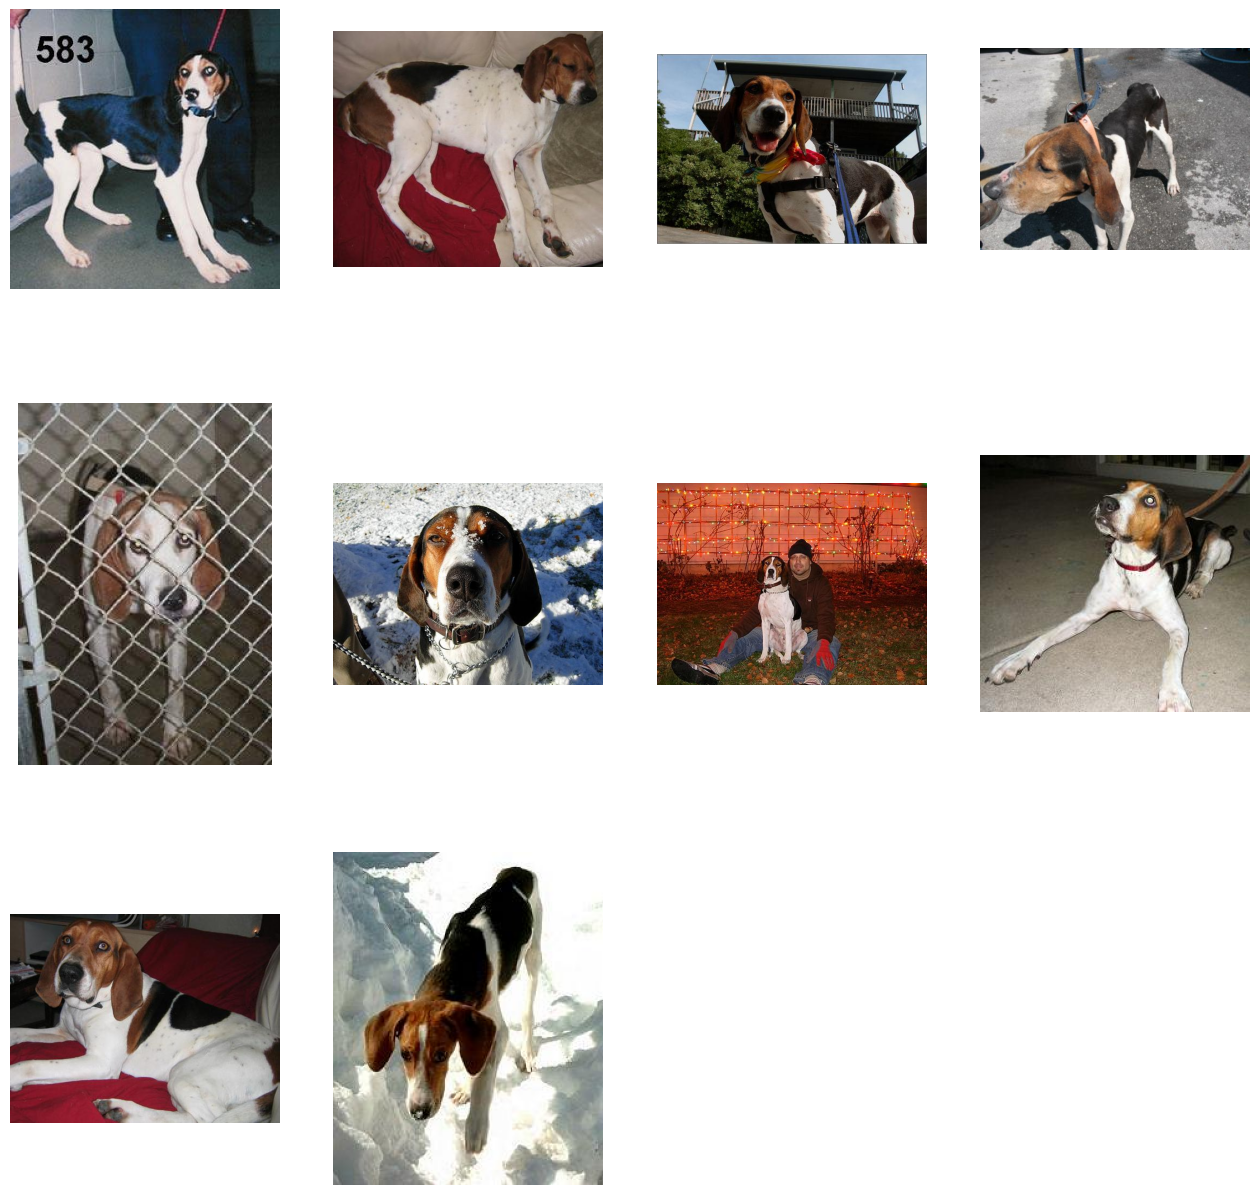

In [5]:
print(breed_list[15])
show_dir_images(breed_list[15], 10)

In [5]:
%%time

# copy from https://www.kaggle.com/gabrielloye/dogs-inception-pytorch-implementation
# reduce the background noise

os.mkdir('data')
for breed in breed_list:
    os.mkdir('data/' + breed)
print('Created {} folders to store cropped images of the different breeds.'.format(len(os.listdir('data'))))

for breed in os.listdir('data'):
    for file in os.listdir("/Users/kassy/Downloads/annotation/Annotation/{}".format(breed)):
        img = Image.open("/Users/kassy/Downloads/images/Images/{}/{}.jpg".format(breed, file))
        tree = ET.parse("/Users/kassy/Downloads/annotation/Annotation/{}/{}".format(breed, file))
        xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
        xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
        ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
        ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img.save('data/' + breed + '/' + file + '.jpg')

FileExistsError: [WinError 183] Não é possível criar um arquivo já existente: 'data'

In [6]:
def paths_and_labels():
    paths = list()
    labels = list()
    targets = list()
    for breed in breed_list:
        base_name = "/Users/kassy/Downloads/data/{}/".format(breed)
        for img_name in os.listdir(base_name):
            paths.append(base_name + img_name)
            labels.append(breed)
            targets.append(label_maps[breed])
    return paths, labels, targets

paths, labels, targets = paths_and_labels()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = to_categorical(targets, num_classes=num_classes)

In [7]:
batch_size = 64

class ImageGenerator(Sequence):
    
    def __init__(self, paths, targets, batch_size, shape, augment=False):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
        self.augment = augment
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_paths = self.paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        x = np.zeros((len(batch_paths), self.shape[0], self.shape[1], self.shape[2]), dtype=np.float32)
        y = np.zeros((self.batch_size, num_classes, 1))
        for i, path in enumerate(batch_paths):
            x[i] = self.__load_image(path)
        y = self.targets[idx * self.batch_size : (idx + 1) * self.batch_size]
        return x, y
    
    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
            
    def __load_image(self, path):
        image = imread(path)
        image = preprocess_input(image)
        if self.augment:
            seq = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5),
                    iaa.Flipud(0.5),
                    iaa.CropAndPad(percent=(-0.25, 0.25)),
                    iaa.Crop(percent=(0, 0.1)),
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    iaa.Affine(
                        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                        rotate=(-180, 180),
                        shear=(-8, 8)
                    )
                ])
            ], random_order=True)
            image = seq.augment_image(image)
        return image

In [8]:
train_paths, val_paths, train_targets, val_targets = train_test_split(paths, 
                                                  targets,
                                                  test_size=0.15, 
                                                  random_state=1029)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3), augment=True)
val_gen = ImageGenerator(val_paths, val_targets, batch_size=32, shape=(224,224,3), augment=False)

In [9]:
inp = Input((224, 224, 3))
backbone = DenseNet121(input_tensor=inp,
                       weights="/Users/kassy/Downloads/DenseNet-BC-121-32-no-top.h5",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
outp = Dense(num_classes, activation="softmax")(x)

model = Model(inp, outp)

In [10]:
for layer in model.layers[:-6]:
    layer.trainable = False

In [11]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

In [12]:
history = model.fit(x=train_gen, 
                    steps_per_epoch=50, 
                    validation_data=val_gen, 
                    validation_steps=50,
                    verbose=1,
                    epochs=10)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 267s 5s/step - acc: 0.0123 - loss: 5.2188 - val_acc: 0.0913 - val_loss: 4.4955
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - acc: 0.0471 - loss: 4.5845 - val_acc: 0.1789 - val_loss: 3.9271
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 248s 5s/step - acc: 0.0850 - loss: 4.0694 - val_acc: 0.3231 - val_loss: 2.9576
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 260s 5s/step - acc: 0.1422 - loss: 3.5299 - val_acc: 0.3867 - val_loss: 2.5321
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - acc: 0.2057 - loss: 3.1976 - val_acc: 0.4831 - val_loss: 2.0472
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 269s 5s/step - acc: 0.2372 - loss: 2.9653 - val_acc: 0.4889 - val_loss: 1.8992
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 302s 6s/step - acc: 0.2469 - loss: 2.7863 - val_acc: 0.5406 - val_loss: 1.6480
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - acc: 0.2907 - loss: 2.6459 - val_acc: 0.5266 - val_loss: 1.6456
Epoch 9/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - acc: 0.3318

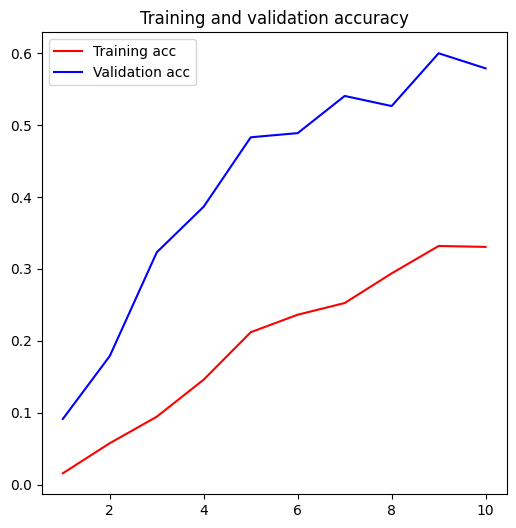

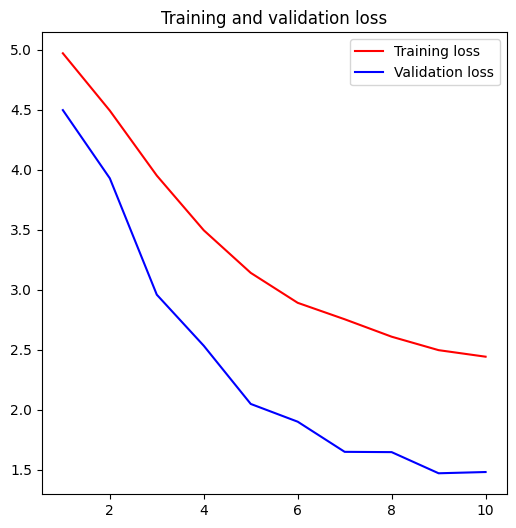

In [13]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [14]:
for layer in model.layers[:]:
    layer.trainable = True

In [15]:
# a check point callback to save our best weights
checkpoint = ModelCheckpoint('dog_breed_classifier_model.weights.h5', 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max', 
                             save_weights_only=True)

# a reducing lr callback to reduce lr when val_loss doesn't increase
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                   patience=1, verbose=1, mode='min',
                                   min_delta=0.0001, cooldown=2, min_lr=1e-7)

# for early stop
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=5)

In [17]:
history = model.fit(x=train_gen, 
                              steps_per_epoch=32, 
                              validation_data=val_gen, 
                              validation_steps=32,
                              verbose=1,
                              epochs=10,
                              callbacks=[checkpoint, reduce_lr, early_stop])
model.save('/Users/kassy/Downloads/modelo_raca_caninas.h5')

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.3665 - loss: 2.2105
Epoch 1: val_acc improved from 0.62402 to 0.65430, saving model to dog_breed_classifier_model.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - acc: 0.3664 - loss: 2.2113 - val_acc: 0.6543 - val_loss: 1.2188 - learning_rate: 0.0010
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.3750 - loss: 2.2535
Epoch 2: val_acc did not improve from 0.65430

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
32/32 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - acc: 0.3744 - loss: 2.2551 - val_acc: 0.6328 - val_loss: 1.2809 - learning_rate: 0.0010
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.3719 - loss: 2.1836
Epoch 3: val_acc did not improve from 0.65430
32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - acc: 0.3726 - loss: 2.1827 - val_acc: 0.6172 - val_loss: 1.2859 - learning_rate: 2.0000e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.3738 - loss: 2.1325
Epoch 4: val_acc im

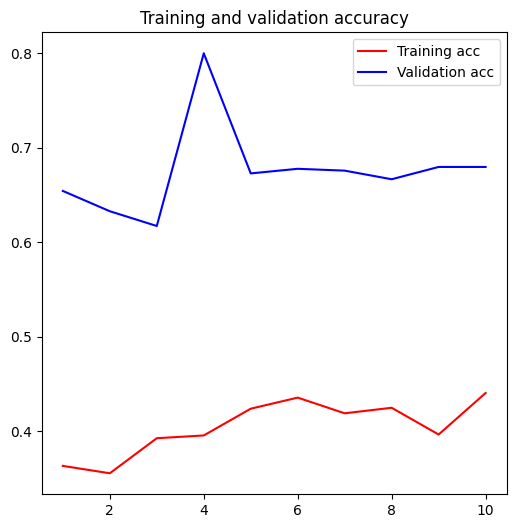

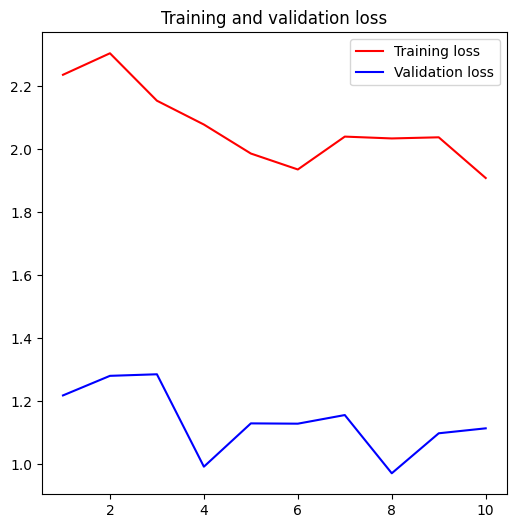

In [18]:
plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [19]:
print(max(val_acc))

0.800000011920929


In [20]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

In [21]:
def previsao_foto(filename):
    # download and save
    os.system("/Users/kassy/Downloads/{}".format(filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = imread(filename)
    img = preprocess_input(img)
    probs = model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
38.74% 	 dhole
19.78% 	 malinois
16.06% 	 German_shepherd
8.08% 	 African_hunting_dog
7.64% 	 dingo


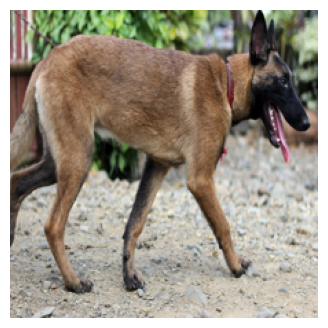

In [22]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
82.08% 	 Pembroke
5.60% 	 dingo
4.46% 	 Cardigan
1.33% 	 dhole
1.09% 	 Siberian_husky


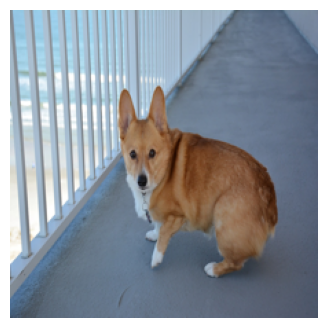

In [23]:
download_and_predict("https://cdn.pixabay.com/photo/2016/07/25/00/06/corgi-1539598_1280.jpg",
                     "test_2.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
55.97% 	 Pembroke
25.88% 	 Cardigan
3.02% 	 Siberian_husky
2.59% 	 papillon
1.89% 	 Shetland_sheepdog


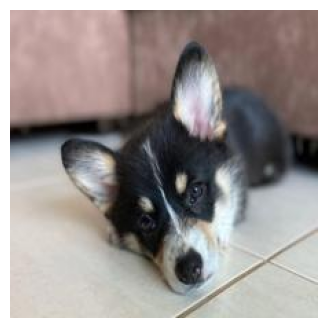

In [24]:
previsao_foto("Olivia.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
22.76% 	 Rhodesian_ridgeback
15.84% 	 boxer
15.53% 	 vizsla
13.08% 	 American_Staffordshire_terrier
6.34% 	 Weimaraner


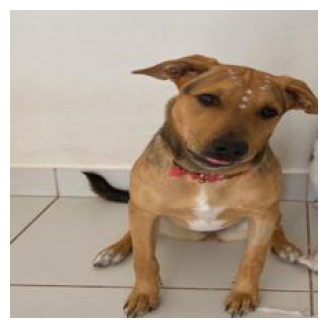

In [27]:
previsao_foto("Agnes.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
14.31% 	 redbone
13.91% 	 Rhodesian_ridgeback
12.19% 	 vizsla
7.30% 	 miniature_pinscher
5.63% 	 Italian_greyhound


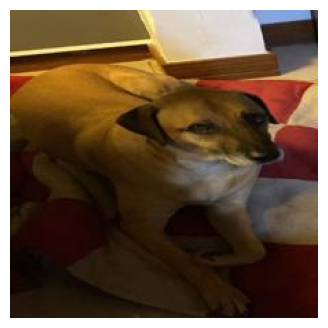

In [28]:
previsao_foto("Leo_1.jpeg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
32.60% 	 Bouvier_des_Flandres
9.43% 	 Tibetan_terrier
9.27% 	 Kerry_blue_terrier
5.52% 	 affenpinscher
5.36% 	 giant_schnauzer


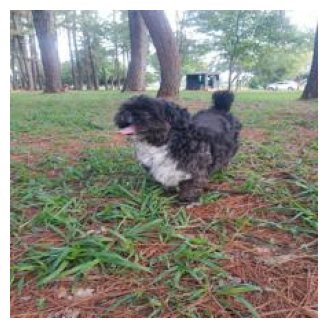

In [29]:
previsao_foto("Leo_2.jpeg")